In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from seaborn import color_palette
from astropy.table import Column
from astropy import units as u
from astropy.io import fits
from specutils import Spectrum1D
from astropy.nddata import StdDevUncertainty
from astropy.io.misc import fnpickle
from astropy.time import TimeDelta
from spectralPhoton import hst

In [2]:
# preliminary setup for wavelength axis
bound_a = [1170.0 * u.Angstrom, 1200.0 * u.Angstrom]
bound_b = [1230 * u.Angstrom, 1355 * u.Angstrom]
low = bound_a[0]
high = bound_b[1]

dlam = 0.009 * u.Angstrom

nl = int(((high - low) / dlam).cgs.value)
wavout = np.arange(nl + 1) * dlam + low  # bin centers
bins_edges = wavout - dlam / 2
# bin edges - SPh uses bin_edges to bin photons into a spectrum
bins_edges = np.append(bins_edges, wavout[-1] + dlam / 2).value

funit = (u.erg) / (u.cm**2 * u.s * u.Angstrom)

In [3]:
# Configure plot
narrow_title = "N V"
narrow_bounds = [1235, 1245]
narrow_plot_bounds = [1235, 1245]
star_name = "AU Mic"
flux_bounds = [-1e-11, 1e-10]
err_bounds = [0.0, 1e-11]
iter_colormap = "plasma"
single_index = 0

In [4]:
# Configure division of TIMETAG data
mode = "count"
write = False

time_window = 200
count_window = 25000

In [5]:
if mode == "count":
    window_width = count_window
elif mode == "time":
    window_width = time_window

In [6]:
# identify individual files
root_folder = "../au_mic_data/"
visit_names = [
        "lebb0" + str(visit_num + 1) for visit_num in range(3)
]

tagfile_roots = []

for visit_name in visit_names:
    all_dirs = os.listdir(root_folder)
    orbit_dirs = [temp_dir for temp_dir in all_dirs
                  if (temp_dir.endswith("q")
                      and temp_dir.startswith(visit_name)
                     )
                 ]
    orbit_starts = np.empty((len(orbit_dirs)))    
    for n_orbit, orbit_dir in enumerate(orbit_dirs):
        orbit_hdu = fits.open(root_folder
                              + orbit_dir
                              + "/"
                              + orbit_dir
                              + "_x1d.fits")
        orbit_starts[n_orbit] = orbit_hdu[1].header["EXPSTART"]
        orbit_hdu.close()
    sort_orbits = np.argsort(orbit_starts)
    sorted_orbit_dirs = np.array(orbit_dirs)[sort_orbits]
    tagfile_roots.append(sorted_orbit_dirs)
print(tagfile_roots)

[array(['lebb01s7q', 'lebb01sbq', 'lebb01sdq', 'lebb01siq', 'lebb01smq'],
      dtype='<U9'), array(['lebb02n2q', 'lebb02n5q', 'lebb02n9q', 'lebb02nzq', 'lebb02o1q'],
      dtype='<U9'), array(['lebb03xpq', 'lebb03xrq', 'lebb03xtq', 'lebb03xvq', 'lebb03xxq'],
      dtype='<U9')]


In [7]:
def mask_spec(spec, flux_bounds, err_bounds):
    good_mask = np.where(
        (np.isfinite(spec[2]))
        & (np.isfinite(spec[3]))
        & (spec[2] < flux_bounds[1])
        & (spec[3] < err_bounds[1])
        & (spec[2] > flux_bounds[0])
        & (spec[3] > err_bounds[0])
    )
    good_spec = Spectrum1D(
        spectral_axis=spec[1][good_mask] * u.AA,
        flux=spec[2][good_mask] * funit,
        uncertainty=StdDevUncertainty(spec[3][good_mask]),
    )
    return good_spec

In [8]:
def get_timerange_lists(star_tag, mode, window_width):
    mjd_0 = star_tag.time_datum
    lc_bandpass = star_tag.lightcurve(
        1,
        [
            np.array([bound_a[0].value, bound_a[1].value]),
            [bound_b[0].value, bound_b[1].value],
        ],
    )
    time_arr = lc_bandpass[2]
    lc_sum = np.cumsum(lc_bandpass[3])
    if mode == "time":
        div_arr = time_arr
    elif mode == "count":
        div_arr = lc_sum
    n_intervals = int(np.round(div_arr[-1] / window_width))
    bin_lefts = np.zeros((n_intervals))
    bin_rights = np.zeros_like(bin_lefts)

    for i in range(n_intervals):
        bin_lefts[i] = np.floor(
            time_arr[np.argmin(np.abs(div_arr - (i * window_width)))]
        )
        bin_rights[:-1] = bin_lefts[1:]
        bin_rights[-1] = np.ceil(lc_bandpass[1][-1])
        bin_lefts[0] = 0.0
        bin_centers = (bin_lefts + bin_rights) / 2.0
        mjds = mjd_0 + TimeDelta(bin_centers, format="sec")

        timerange_list = [
            [np.array([bin_left, bin_right])]
            for bin_left, bin_right in zip(bin_lefts, bin_rights)
        ]
    return timerange_list, mjds

In [9]:
def get_slice_spectra(star_tag, timerange_list, flux_bounds=[-1e-11, 1e-10], err_bounds=[0.0, 1e-11]):
    slice_spectra = []
    for i in range(len(timerange_list)):
        raw_spec = star_tag.spectrum(
            bins_edges, fluxed=True, time_ranges=timerange_list[i]
        )
        slice_spectra.append(mask_spec(raw_spec, flux_bounds, err_bounds))
    return slice_spectra

In [10]:
def plot_diagnostic_orbit(star_tag,
                          all_spec,
                          slice_spectra,
                          mode,
                          bin_lefts,
                          savename,
                          narrow_title,
                          narrow_bounds,
                          iter_colormap,
                          write=False,
                         single_index=0):
    lc_bandpass = star_tag.lightcurve(
        1,
        [np.array([bound_a[0].value, bound_a[1].value]),
         [bound_b[0].value, bound_b[1].value],],
    )
    time_arr = lc_bandpass[2]
    lc_narrow = star_tag.lightcurve(1, [np.array(narrow_bounds)])
    lc_sum = np.cumsum(lc_narrow[3])

    f, _ = plt.subplot_mosaic(
        [
            ["upper left", "center-left", "center-right", "right"],
            ["lower left", "center-left", "center-right", "right"],
        ],
        figsize=(18, 5),
    )
    ax_lc, ax_tot, ax_single, ax_narrow, ax_sum = f.axes
    plt.suptitle(star_name.replace("_", " "))
    
    ax_lc.set_ylabel("Count rate [counts / second]")
    ax_lc.errorbar(
        lc_bandpass[2], lc_bandpass[3], yerr=lc_bandpass[4]
    )
    for bin_left in bin_lefts:
        ax_sum.axvline(bin_left, color="k", ls=":")
    ax_sum.plot(time_arr, lc_sum)
    ax_sum.set_xlabel("Time [seconds]")
    ax_sum.set_ylabel("Cumulative Counts [counts]")
    
    ax_tot.errorbar(
        all_spec.spectral_axis.value,
        all_spec.flux.value,
        yerr=all_spec.uncertainty.array,
        drawstyle="steps-mid",
    )
    ax_tot.set_xlabel(r"Wavelength [$\mathrm{\AA}$]")
    ax_tot.set_ylabel(
        r"Flux Density [erg s$^{-1}$ cm$^{-2}$ $\mathrm{\AA}^{-1}$]"
    )
    ax_tot.set_title("Total Time Spectrum")
    
    single_spec = slice_spectra[single_index]
    ax_single.errorbar(
        single_spec.spectral_axis.value,
        single_spec.flux.value,
        yerr=single_spec.uncertainty.array,
        drawstyle="steps-mid",
    )
    ax_single.sharex(ax_tot)
    ax_single.sharey(ax_tot)
    ax_single.set_xlabel(r"Wavelength [$\mathrm{\AA}$]")
    ax_single.set_ylabel(
        r"Flux Density"
        + r" [erg s$^{-1}$ cm$^{-2}$ $\mathrm{\AA}^{-1}$]"
    )
    ax_single.set_title("Individual "
                        + mode.capitalize()
                        + " Bin: "
                        + str(int(single_index)))
    
    iter_colors = color_palette(iter_colormap, len(slice_spectra))
    for iter_color, spec in zip(iter_colors, slice_spectra):
        narrow_mask = np.where(
        (spec.spectral_axis.value < narrow_plot_bounds[1])
        & (spec.spectral_axis.value > narrow_plot_bounds[0])
        )
        ax_narrow.errorbar(
        spec.spectral_axis.value[narrow_mask],
        spec.flux.value[narrow_mask],
        yerr=spec.uncertainty.array[narrow_mask],
        drawstyle="steps-mid",
        alpha=0.3,
        color=iter_color
        )

        ax_narrow.set_xlabel(r"Wavelength [$\mathrm{\AA}$]")
    ax_narrow.set_ylabel(
    r"Flux Density"
    + r" [erg s$^{-1}$ cm$^{-2}$ $\mathrm{\AA}^{-1}$]"
    )
    ax_narrow.set_title(narrow_title)

    plt.tight_layout()
    if write:
        plt.savefig(savename)
    plt.show()

In [11]:
def write_slice_spectra(star_name, mode, window_width, visit_num, orbit_num):
    fnpickle(
        mjds.mjd,
        root_folder
        + "/slice_spectra/"
        + star_name
        + "_"
        + "v"
        + str(visit_num)
        + "_"
        + mode[0]
        + "_"
        + str(int(window_width))
        + "_o"
        + str(int(orb_num))
        + "_mjds.pkl",
    )
    for spec in slice_spectra:
        new_spec.write(
        root_folder
        + "/slice_spectra/"
        + star_name
        + "_"
        + "v"
        + str(visit_num)
        + "_"
        + mode[0]
        + "_"
        + str(int(window_width))
        + "_o"
        + str(int(orb_num))
        + "_i"
        + str(i)
        + ".fits",
        format="tabular-fits",
        overwrite=True,
    )

In [12]:
def process_orbit(star_name, tagfile_roots, visit_num, orbit_num, narrow_bounds, narrow_title, flux_bounds, err_bounds, mode, window_width, plot_name=None, plot=True, write=False, iter_colormap="plasma", single_index=0):
    tagfile_root = tagfile_roots[visit_num][orbit_num]

    star_tag = hst.readtagset(root_folder + tagfile_root + "/", flux_bins=None)

    raw_all_spec = star_tag.spectrum(bins_edges, fluxed=True)
    all_spec = mask_spec(raw_all_spec,
                         flux_bounds,
                         err_bounds)

    timerange_list, mjds = get_timerange_lists(star_tag, mode, window_width)
    slice_spectra = get_slice_spectra(star_tag, timerange_list, flux_bounds, err_bounds)
    
    bin_lefts = [timerange[0][0] for timerange in timerange_list]

    if plot:
        plot_diagnostic_orbit(star_tag, all_spec, slice_spectra, mode, bin_lefts, plot_name, narrow_title, narrow_bounds, iter_colormap, write, single_index)
    if write:
        write_slice_spectra(star_name, mode, window_width, visit_num, orbit_num)

In [13]:
def process_visit(star_name, tagfile_roots, visit_num, narrow_bounds, narrow_title, flux_bounds, err_bounds, mode, window_width, plot_name=None, plot=True, write=False, iter_colormap="plasma", single_index=0):
    n_orbits = len(tagfile_roots[visit_num])
    for orbit_num in range(n_orbits):
        try:
            process_orbit(star_name, tagfile_roots, visit_num, orbit_num, narrow_bounds, narrow_title, flux_bounds, err_bounds, mode, window_width, plot_name, plot, write, iter_colormap, single_index)
        except ValueError:
            print("Bandpass issue?", visit_num, orbit_num)

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


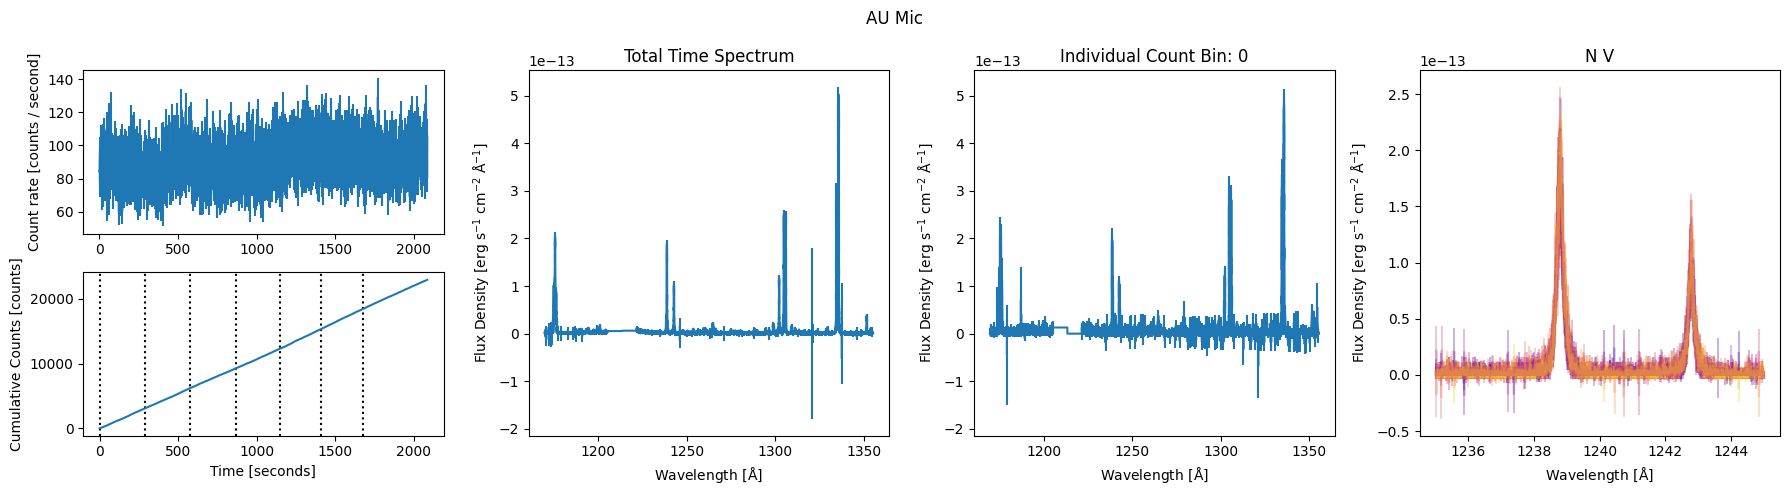

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


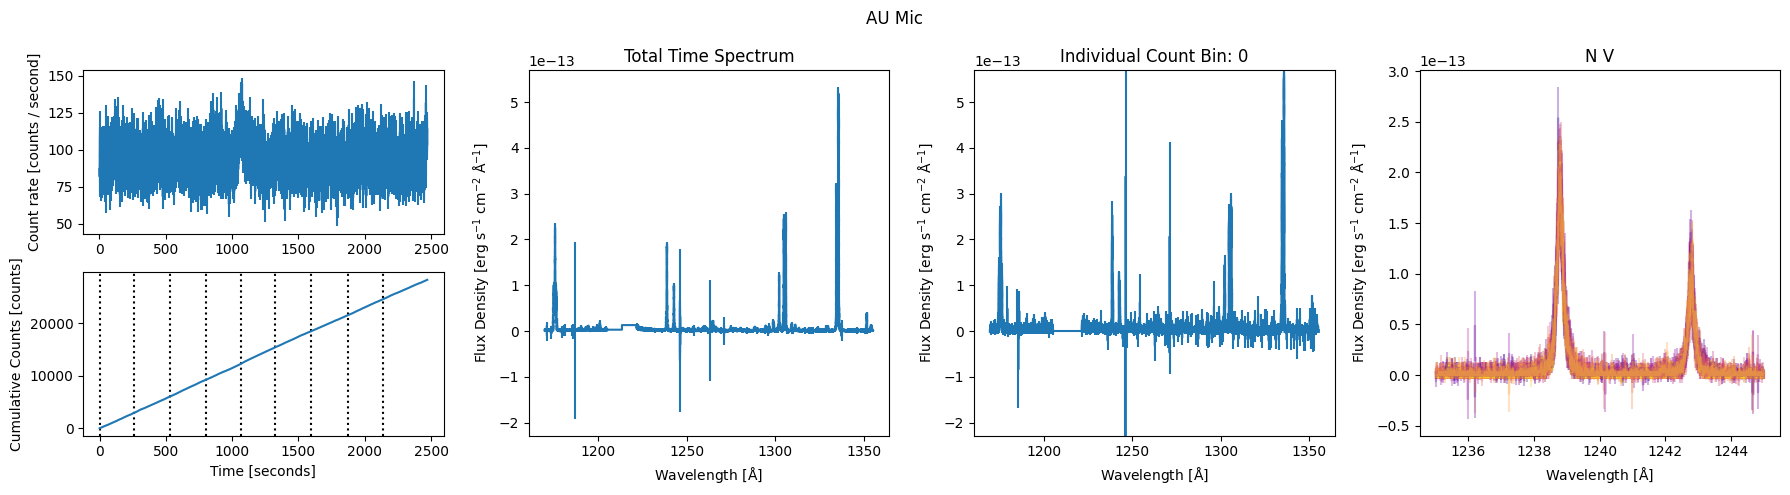

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


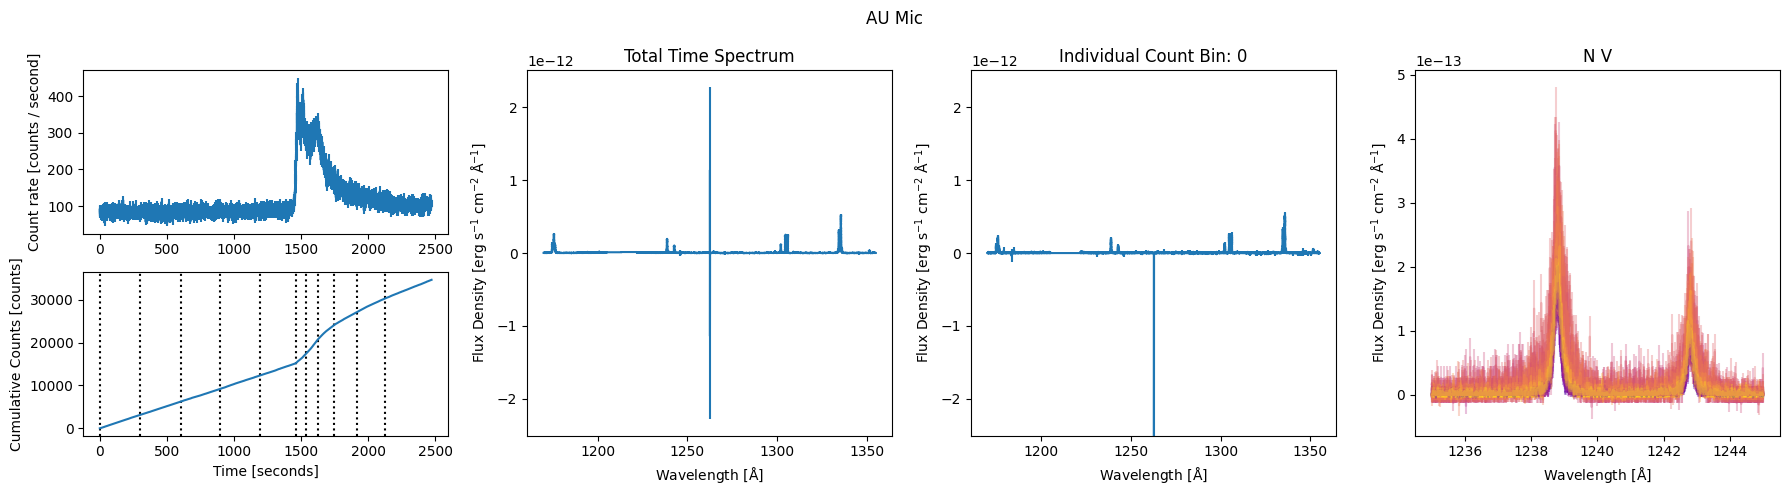

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


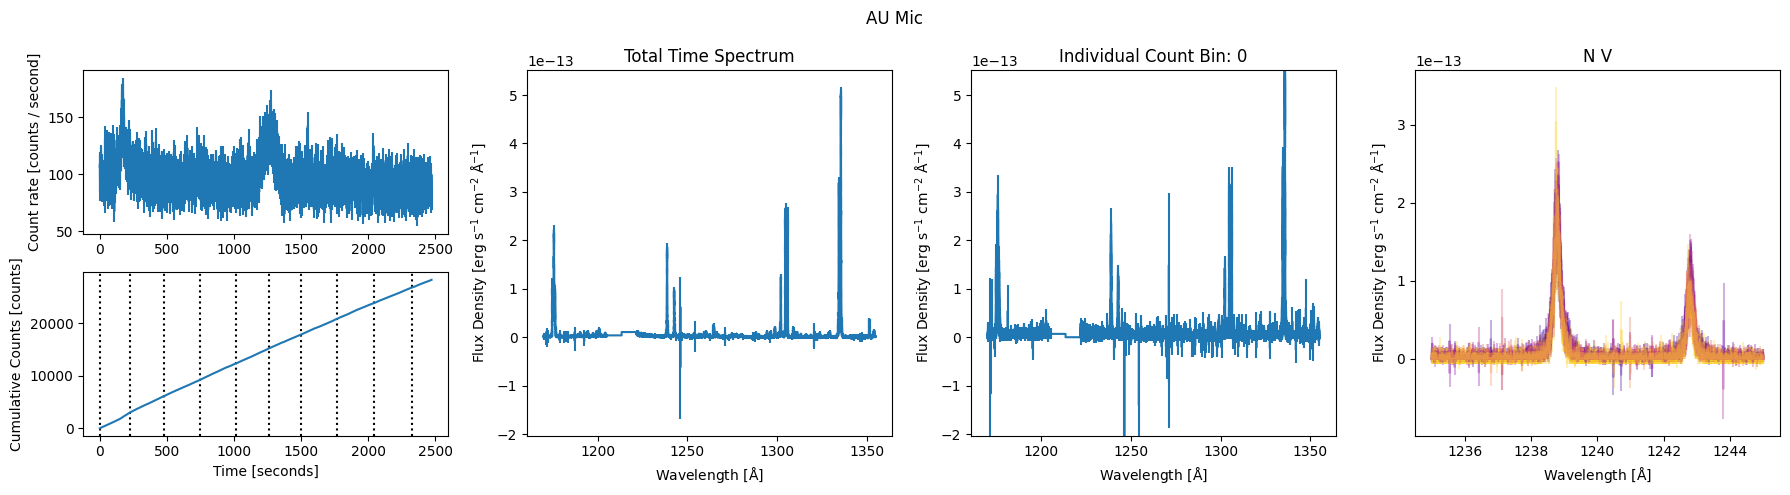

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


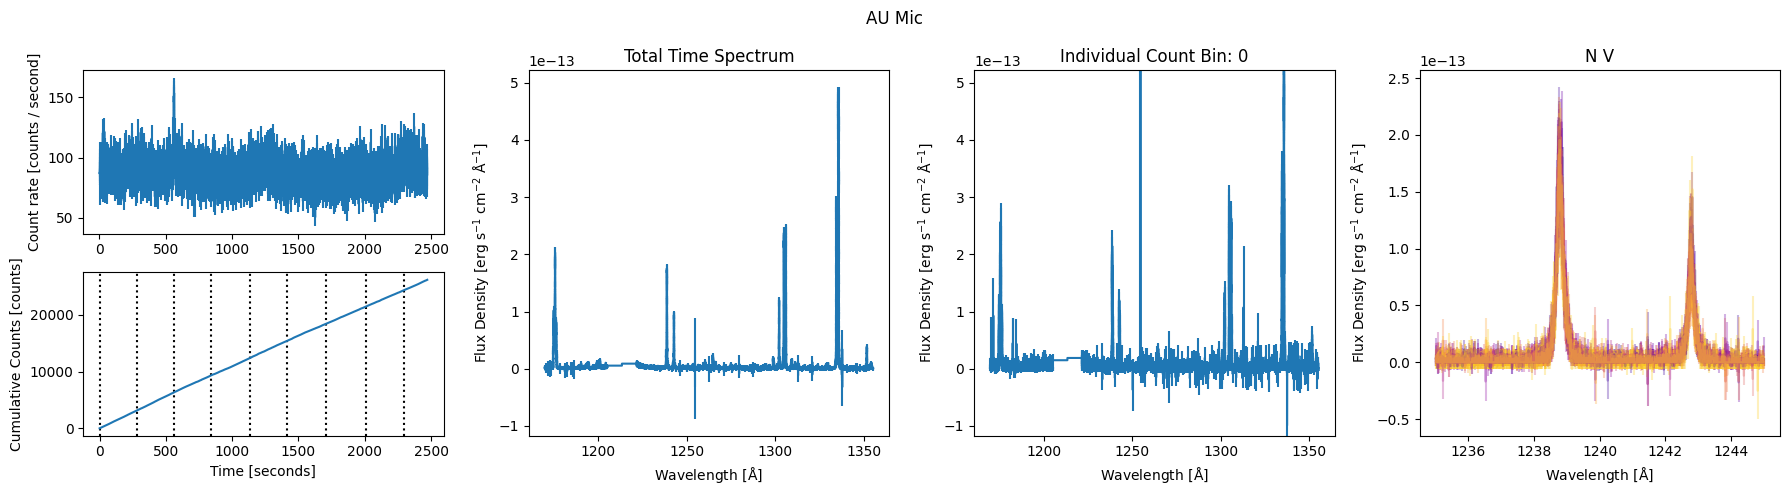

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


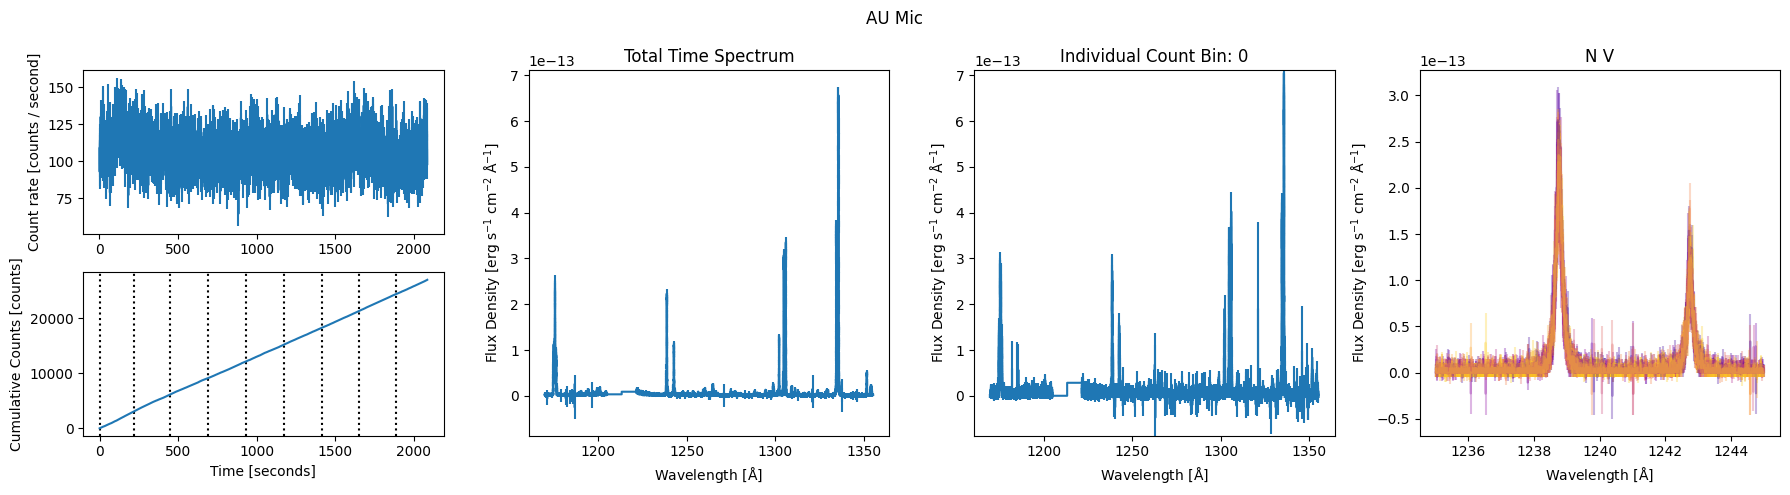

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


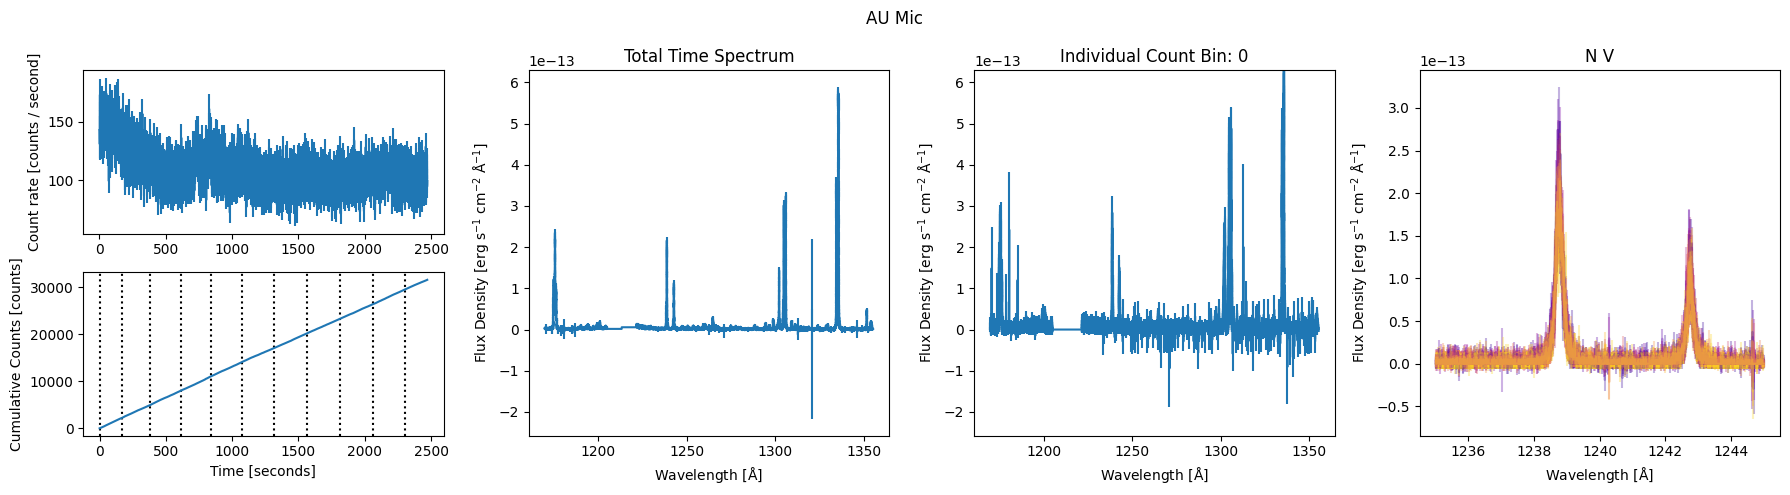

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


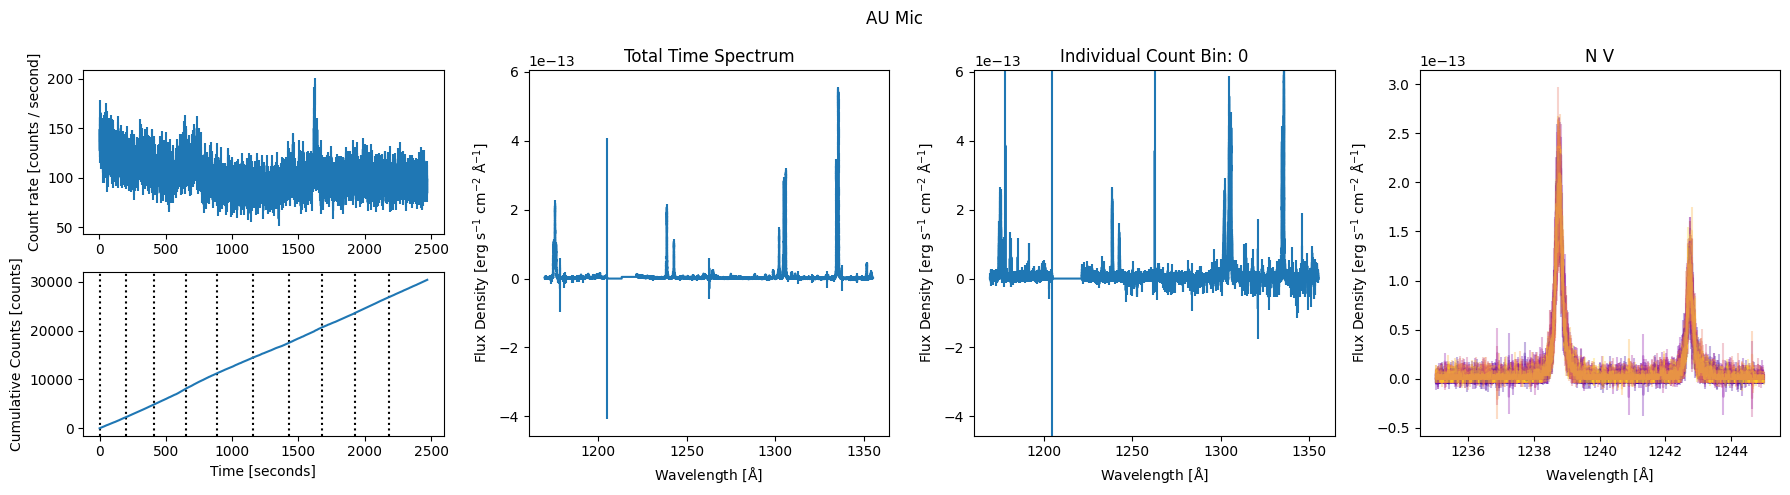

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


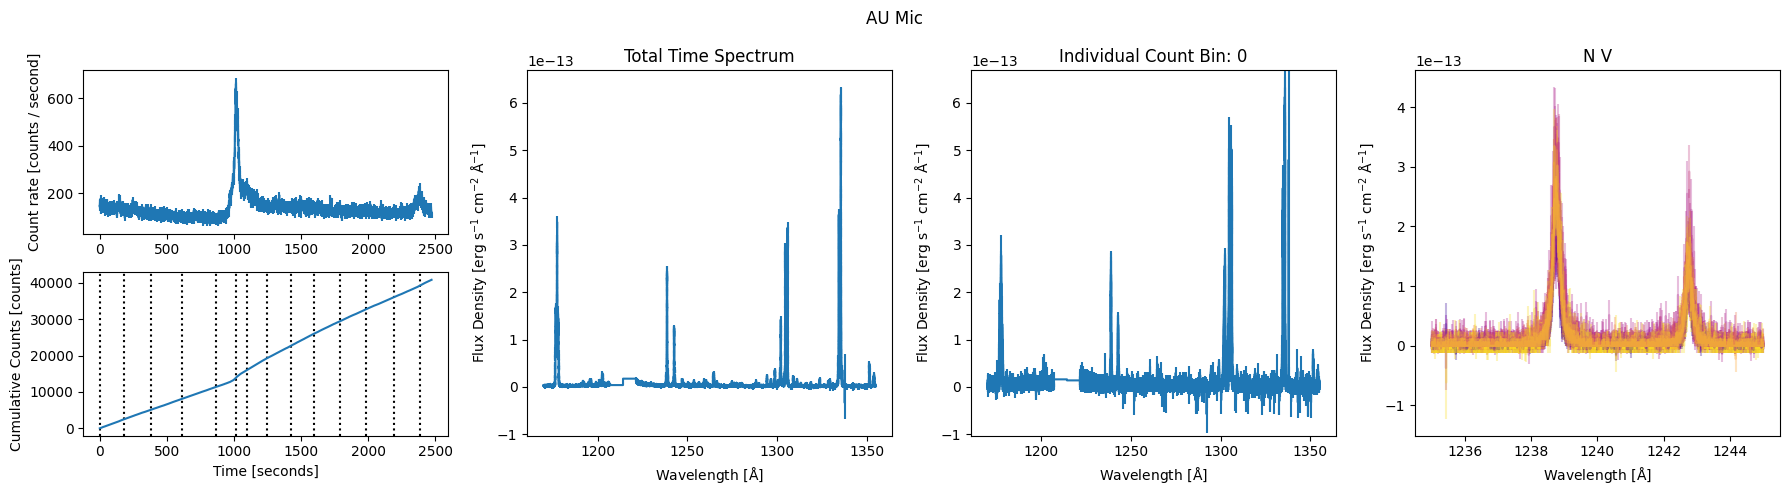

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


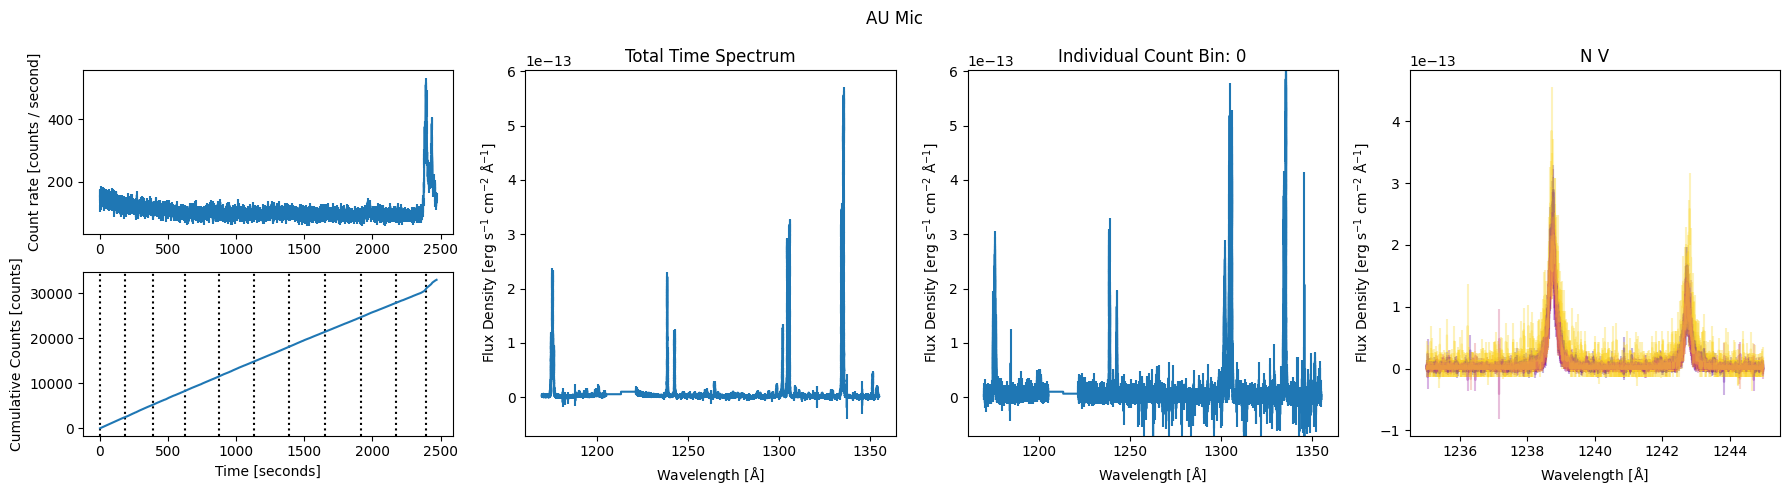

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


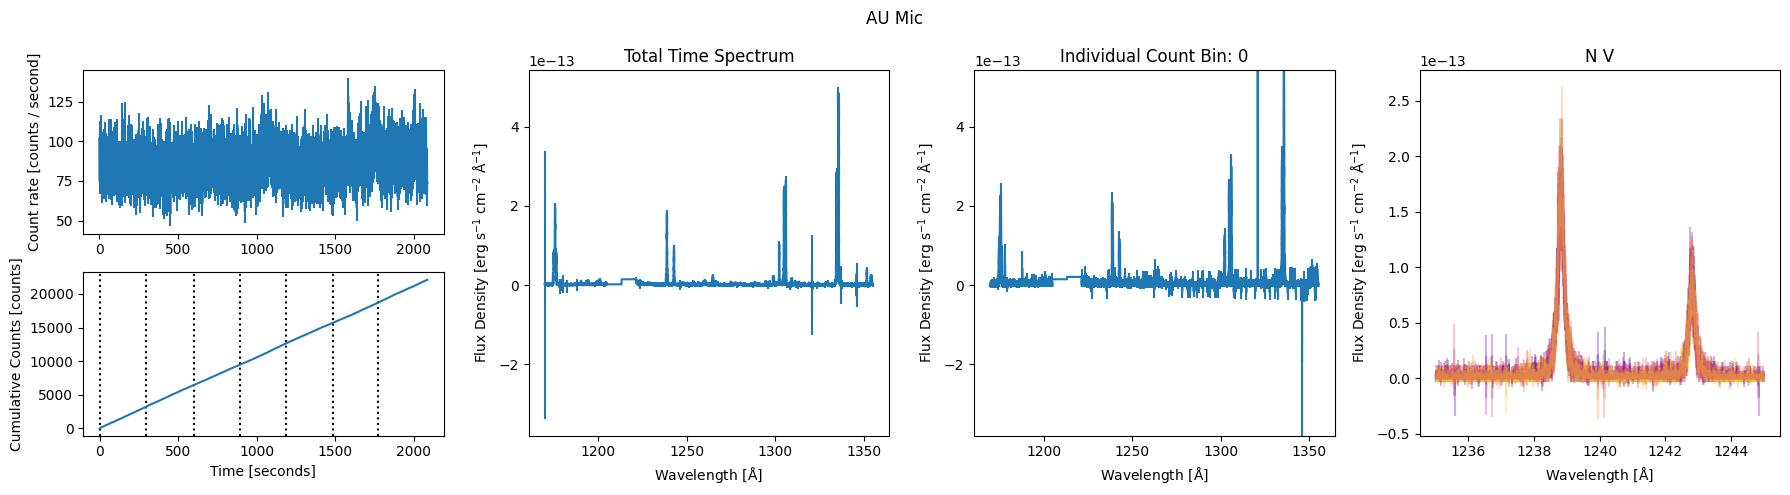

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


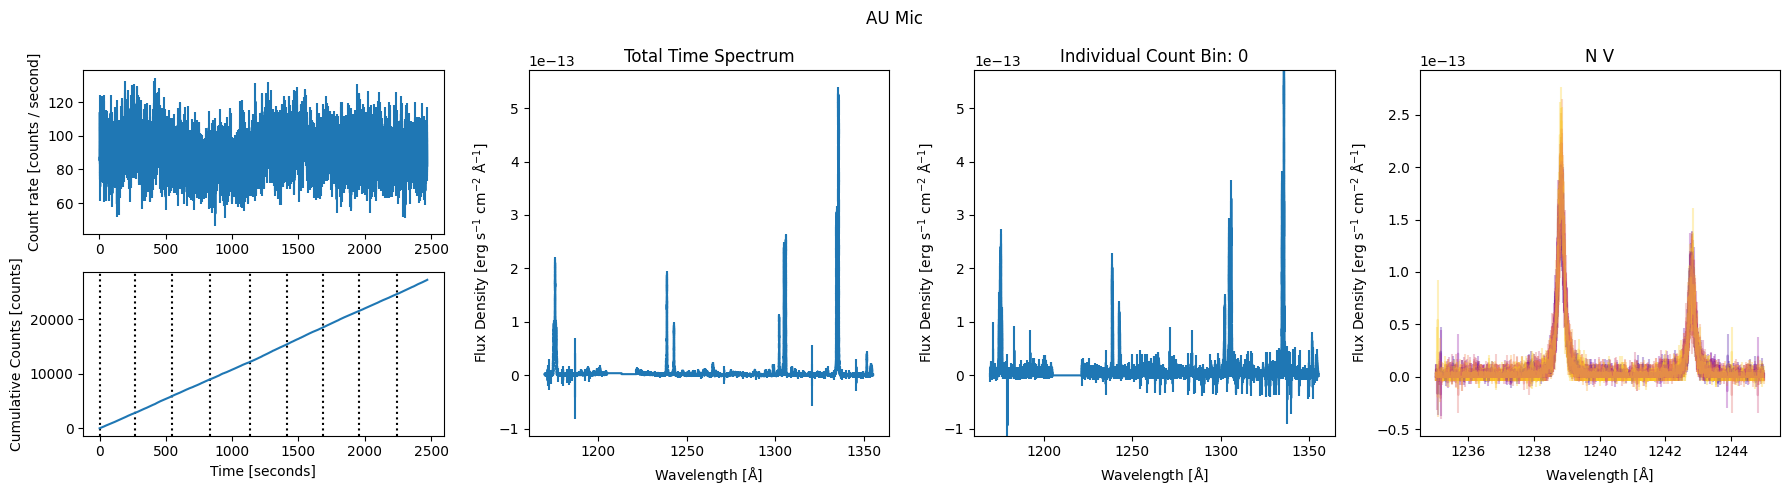

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


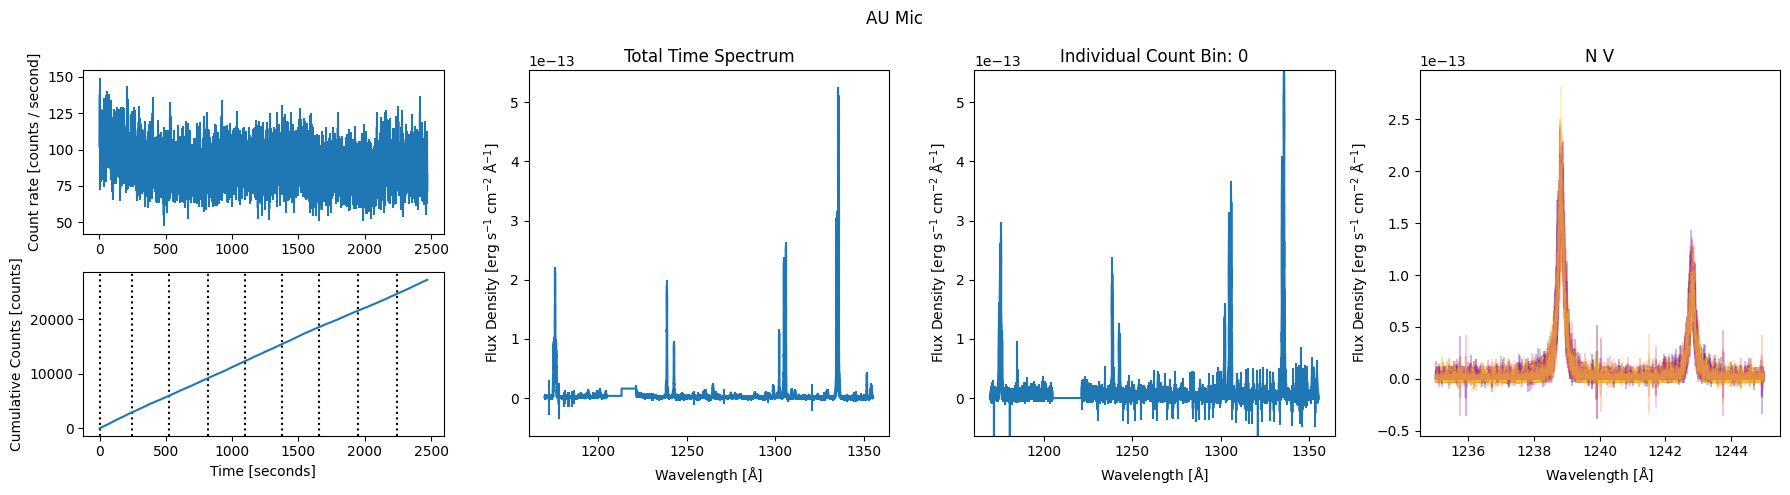

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


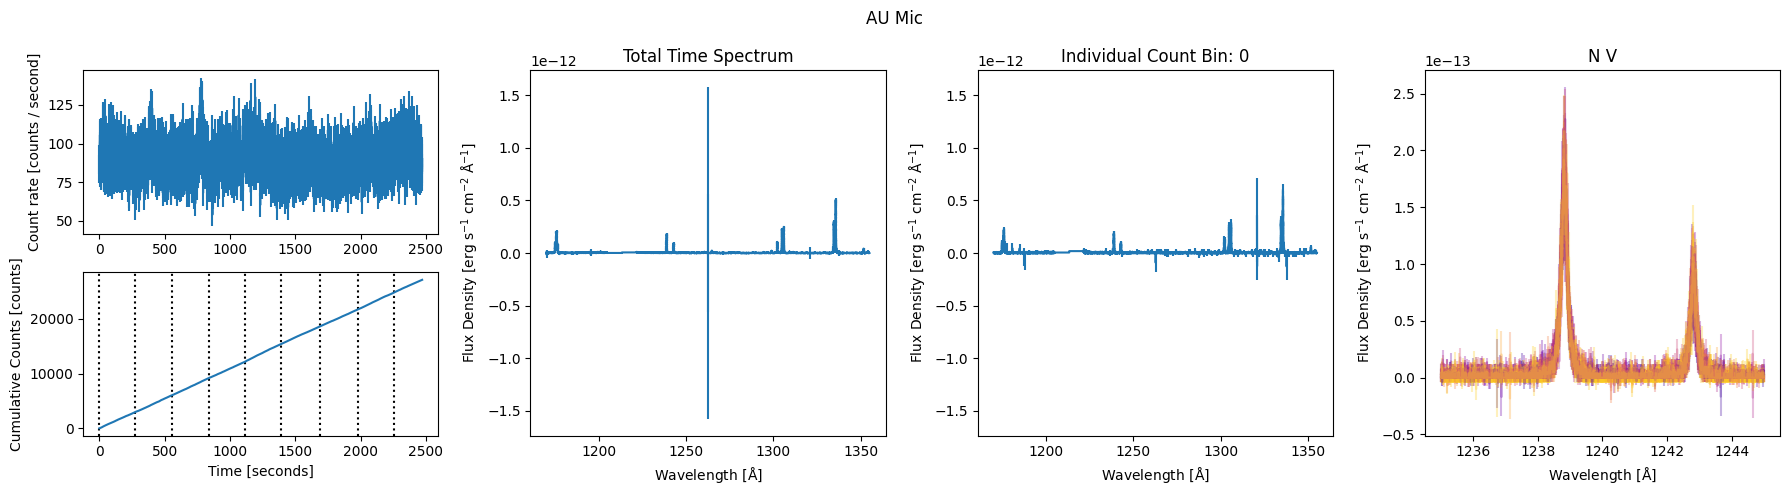

/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1608: RuntimeWarning: divide by zero encountered in divide
  epera = energy / self["a"]
/home/gmduvvuri/repos_all/research/spectralPhoton/spectralPhoton/data_structures.py:1629: RuntimeWarning: invalid value encountered in multiply
  weights *= self._compute_epera(units=energy_units)


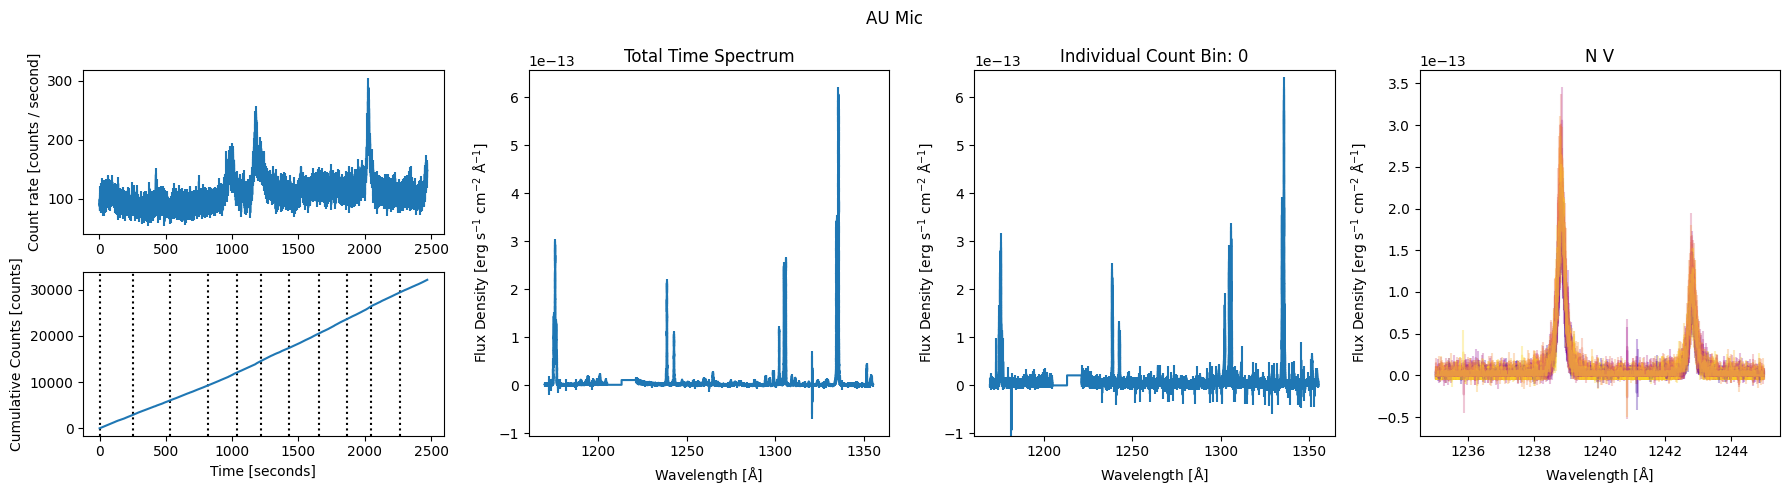

In [14]:
for visit_num in range(3):
    process_visit(star_name, tagfile_roots, visit_num, narrow_bounds, narrow_title, flux_bounds, err_bounds, mode, window_width, plot_name=None, plot=True, write=False, single_index=single_index)